# NYC Subway Analysis and Forecasting

For this project, we are going to analyze NYC Subway turnstile information to help us answer the following:
- Which lines have the most trafic?
- Which station stops have the most traffic?
- Can we forecast traffic into NYC subway stations?

We are going to pull 2018 NYC Subway turnstile data to forecast for 2019.

## **Data Setup**

### *Import Libraries & Options*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
import datetime
import dill

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_columns', None)
plt.style.use('tableau-colorblind10')

### *Import Data*

http://web.mta.info/developers/data/nyct/turnstile/turnstile_171230.txt

For MTA turnstile data, we are going to run through each file and append to a larger dataframe. On the MTS website, each file is generated every 7 days.

First, we are going to load the initial data set from 12/30/17. 

Because this dataset takes a while to load, we are going to load from the previous state if it exists. If not, we will scrape the data from the mta developers api.

In [2]:
try:
    dill.load_session('nyc_subway_forecast.db')
    print('Session found! Data and vairables loaded!')
    
except FileNotFoundError: 
    print('File not found! Loading data and variables for first time....')
    
    #Load in the intial data file
    data_df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_150103.txt')
    
    #Create date stamp column in dataframe
    data_df['DATE_STAMP'] = pd.to_datetime(data_df.DATE)
    data_df['TEST'] = data_df['ENTRIES'].diff()
    
    
    #Create list of dates for file suffix
    filedates = []
    fileStartdate = '150103'
    fileEnddate = '190101'
    date_1 = datetime.datetime.strptime(fileStartdate, "%y%m%d")
    filedates.append((date_1 + datetime.timedelta(days=7)).strftime('%y%m%d'))

    #Fill in list that contains the date suffix for each file from 12/30/17 to 12/31/18. 
    for dates in filedates:
        if fileStartdate < fileEnddate:
            date_1 = (datetime.datetime.strptime(dates, "%y%m%d") + datetime.timedelta(days=7)).strftime('%y%m%d')
            filedates.append(date_1)
            fileStartdate = date_1
            
    #Next step is to append files to our intialized turnstile dataframe from above.We are going to create a date stamp column for each load.
    for dates in filedates:
        tmp_df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(dates))
        tmp_df['DATE_STAMP'] = pd.to_datetime(tmp_df.DATE)
        tmp_df['TEST'] = tmp_df['ENTRIES'].diff()
        data_df = data_df.append(tmp_df)
    
    #Save jupyter state
    dill.dump_session('nyc_subway_forecast.db')
    
    print('Data loaded successfully!')

Session found! Data and vairables loaded!


## **Data Exploration**

In [3]:
data_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_STAMP,TEST
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,12/27/2014,03:00:00,REGULAR,4936840,1672747,2014-12-27,NaN
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,12/27/2014,07:00:00,REGULAR,4936852,1672762,2014-12-27,12.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,12/27/2014,11:00:00,REGULAR,4936909,1672839,2014-12-27,57.0
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,12/27/2014,15:00:00,REGULAR,4937131,1672892,2014-12-27,222.0
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,12/27/2014,19:00:00,REGULAR,4937588,1672949,2014-12-27,457.0


In [4]:
data_df.dtypes

C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DATE                                                                            object
TIME                                                                            object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
DATE_STAMP                                 

In [5]:
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
data_df.describe()

,ENTRIES,EXITS,TEST
count,4.106270e+07,4.106270e+07,4.106249e+07
mean,3.576123e+07,2.890921e+07,-2.792697e+01
std,1.961858e+08,1.779702e+08,4.066654e+07
min,0.000000e+00,0.000000e+00,-2.147438e+09
25%,5.152920e+05,2.615820e+05,9.000000e+00
50%,2.523039e+06,1.454654e+06,7.500000e+01
75%,6.557582e+06,4.647384e+06,2.500000e+02
max,2.147483e+09,2.146093e+09,2.147361e+09


The test value tells us the difference from the previous value. In theory, the values should not deviate far from each other unless there is a data integrity issue. Here, the test value's std deviation value is much higher than mean.

In [6]:
# Get a listing of columns in the dataframe
columns = data_df.columns

In [7]:
# Print out name of columns and number of columns
print(columns)

print('Number of columns:', len(columns))

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               ',
       'DATE_STAMP', 'TEST'],
      dtype='object')
Number of columns: 13


Looking at our colulmns, there are 13 columns. The 'Exits' columns has some extra characters. Let's rename it.

In [8]:
# Rename the 'EXITS' columns
data_df.rename(columns={'EXITS                                                               ': 'EXITS'}, inplace=True)
columns = data_df.columns

Next, we will get the number of unique values for each column.

In [9]:
# Number of unique values for each column
data_df.nunique()

C/A                750
UNIT               471
SCP                256
STATION            572
LINENAME           128
DIVISION             6
DATE              1470
TIME             86400
DESC                 2
ENTRIES       13312565
EXITS         11439202
DATE_STAMP        1470
TEST            904312
dtype: int64

Looking at 'DIVISION' and 'DESC' we see a small number of unique values. Let's take a look at those.

In [10]:
data_df['DIVISION'].unique()

array(['BMT', 'IND', 'PTH', 'IRT', 'SRT', 'RIT'], dtype=object)

In [11]:
data_df['DESC'].unique()

array(['REGULAR', 'RECOVR AUD'], dtype=object)

Exploring our data further, we see the following columns:
- C/A – The Control Area is the operator booth in a station. Some stations only have one operator booth. However, larger stations may have more than one.

- UNIT – The Remote Unit, which is the collection of turnstiles. A station may have more than one Remote Unit.

- SCP – The Subunit Channel Position represents the turnstile and the number used may repeat across stations. The UNIT and SCP together is a unique identifier of a turnstile.

- DATE – The Date is the date of the recording with the format MM/DD/YYYY.

- TIME – The Time is the time for a recording, with the format: HH:MM:SS.

- DESC – The DESC is the type of event of the reading. The turnstiles submit “Regular” readings every four hours. They stagger the exact time of the readings across all the turnstiles and stations. Staggering the data submission times avoids having all the turnstiles update at simultaneously. “Recover Audit” designates scheduled readings taken after a communication outage. Our analysis uses “Regular” and “Recover Audit” readings. We discard other values such as “DoorClose” and “DoorOpen” which represent unscheduled maintenance readings.

- ENTRIES = The ENTRIES are a cumulative count of turnstile entrances. Note, the ENTRIES do not reset each day or for each recording period. The turnstile entry count continues to increase until it reaches the device limit and then resets to zero.

- EXITS = The EXITS are a cumulative count of the turnstile exits.

Since the UNIT and SCP together make a unique turnstile, we are going to create a columns that creates a unique record for the turnstiles by merging those two columns together.

In [12]:
data_df['TURNSTILE'] = data_df['UNIT']+'.'+data_df['SCP']

Next, we are going to filter for "Regular" and "Recovery Audit" readings in the DESC column.

In [13]:
turnstile_df = data_df[(data_df['DESC'] == 'RECOVR AUD') | (data_df['DESC'] == 'REGULAR')]

Focusing on the Entries and Exits column, the turnstiles record each time a passenger enters and exits through it. Every four hours, they send a time-stamped running tally of the entries and exits. The data shows that the tally increases with every reading. The turnstiles reset when their counters reach their maximum limit. To determine how many people enter through a turnstile, we subtract the previous time stamped Entries reading with the current number of Entries.
We need to group the 'UNIT' and 'SCP' columns together to get difference between readings. 

R has a built-in function diff with outputs the difference of between consecutive rows. The ave function groups each booth and turnstile as a subset. By combining the diff and ave function, we can determine the entries and exits of each turnstile.
These links go in depth explanations about the diff function and ave.

So only UNIT "R305" has turnstiles that belong to more than one station. This is the newly opened "WTC-CORTLANDT" station.

##### Create a column for maximum timestamp & a maximum time dataframe

In [14]:
#Create a Key for tunrstile/date combination
turnstile_df['KEY'] = turnstile_df['TURNSTILE']+'.'+turnstile_df['DATE']

For each day, we are going to retrieve the maximum time stamp for each turnstile key/day.

In [15]:
#Get maximum number of entries for each turnstile for a given day
maxTimeDF = turnstile_df.groupby(['KEY'])['TIME'].max().reset_index()
maxTimeDF.rename(columns={"TIME": "MAX_TIME"}, inplace=True)

#Get minimum number of entries for each turnstile for a given day
minTimeDF = turnstile_df.groupby(['KEY'])['TIME'].min().reset_index()
minTimeDF.rename(columns={"TIME": "MIN_TIME"}, inplace=True)

#Merge the min and max values with turnstile dataframe
turnstile_df = turnstile_df.merge(maxTimeDF[['KEY', 'MAX_TIME']], left_on=['KEY'], right_on=['KEY'], how='left')
turnstile_df = turnstile_df.merge(minTimeDF[['KEY', 'MIN_TIME']], left_on=['KEY'], right_on=['KEY'], how='left')

#Rank each time stamp
turnstile_df['RANK'] = turnstile_df.groupby(['KEY'])['TIME'].cumcount()

In [16]:
#Sort turnstile dataframe by the turnstile and time stamp in ascendimg order
turnstile_df = turnstile_df.sort_values(['TURNSTILE','DATE_STAMP', 'TIME'],ascending=True)
turnstile_df['DAILY_ENTRIES'] = turnstile_df['ENTRIES'].diff()

#Mask the rows that have reset in entriy counts as we go to new turnstile. Assign nan values to those rows
mask = turnstile_df['TURNSTILE'] != turnstile_df['TURNSTILE'].shift(1)
turnstile_df['DAILY_ENTRIES'][mask] = np.nan

We need to determine what can we consider the actual count of entries for each turnstile. FIrst, I want to understand the distribution of change in entries by hour.

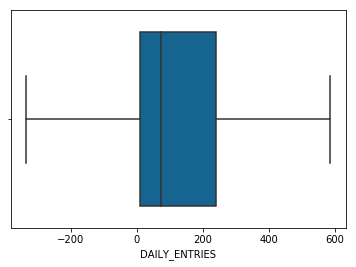

In [17]:
sns.boxplot(turnstile_df['DAILY_ENTRIES'], orient='h', showfliers=False)
plt.show()

In [18]:
#Print out percentiles
percentile_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
for i in percentile_values:
    print([i], turnstile_df['DAILY_ENTRIES'].quantile(i))

[0] -2147369278.0
[0.01] 0.0
[0.02] 0.0
[0.03] 0.0
[0.04] 0.0
[0.05] 0.0
[0.06] 0.0
[0.07] 0.0
[0.08] 0.0
[0.09] 0.0
[0.1] 0.0
[0.2] 4.0
[0.3] 18.0
[0.4] 39.0
[0.5] 74.0
[0.6] 125.0
[0.7] 195.0
[0.8] 299.0
[0.9] 488.0
[0.95] 688.0
[0.96] 755.0
[0.97] 844.0
[0.98] 978.0
[0.99] 1217.0
[1.0] 2144926678.0


So we will say that if a test value is greater than 99th percentile, ignore it.

In [19]:
#Create an analysis flag to only include Next values less than the 98th percentile AND greater than 2nd percentile
upper_threshold = turnstile_df['DAILY_ENTRIES'].quantile(0.995)
lower_threshold = turnstile_df['DAILY_ENTRIES'].quantile(0.01)

turnstile_df['ANALYSIS'] = turnstile_df['DAILY_ENTRIES'].apply(lambda x: 1 if (x <= upper_threshold and x > lower_threshold) else 0)

If we look at the first few entries, we see that the difference counts are zero. This could signal some sort of count error or malfunction. We are going to take the highest time stamp for each trurnstile key and day combo where the analysis is flagged=1.

In [20]:
#Create an analysis dataframe that filters for rows with analysis=1 and TIME = MAX_TIME
analysis_df = turnstile_df[(turnstile_df['ANALYSIS'] == 1)]

#### *NYC Subway Traffic 2018*

##### Totals By Station

In [21]:
#Filter for 2018 recordings only
dailyTurnstile2018 = analysis_df[(analysis_df['DATE_STAMP'] >= '2018-01-01') & (analysis_df['DATE_STAMP'] <= '2018-12-31')]

In [23]:
#Group by date and sum entries by station
dailyTurnstile2018['STATION_KEY'] = dailyTurnstile2018['STATION']+'_'+dailyTurnstile2018['LINENAME']
totalByStation2018 = dailyTurnstile2018.groupby(['STATION', 'STATION_KEY'], as_index=False)['DAILY_ENTRIES'].sum()
totalByStation2018.rename(columns={"DAILY_ENTRIES": "TOTAL_ENTRIES"}, inplace=True)

In [25]:
#Create a column that displays the output in millions
totalByStation2018['TOTAL_ENTRIES_IN_MILLIONS'] = totalByStation2018['TOTAL_ENTRIES']/1000000

Next, we are going to plot out the top 15 stations in terms of station entries.

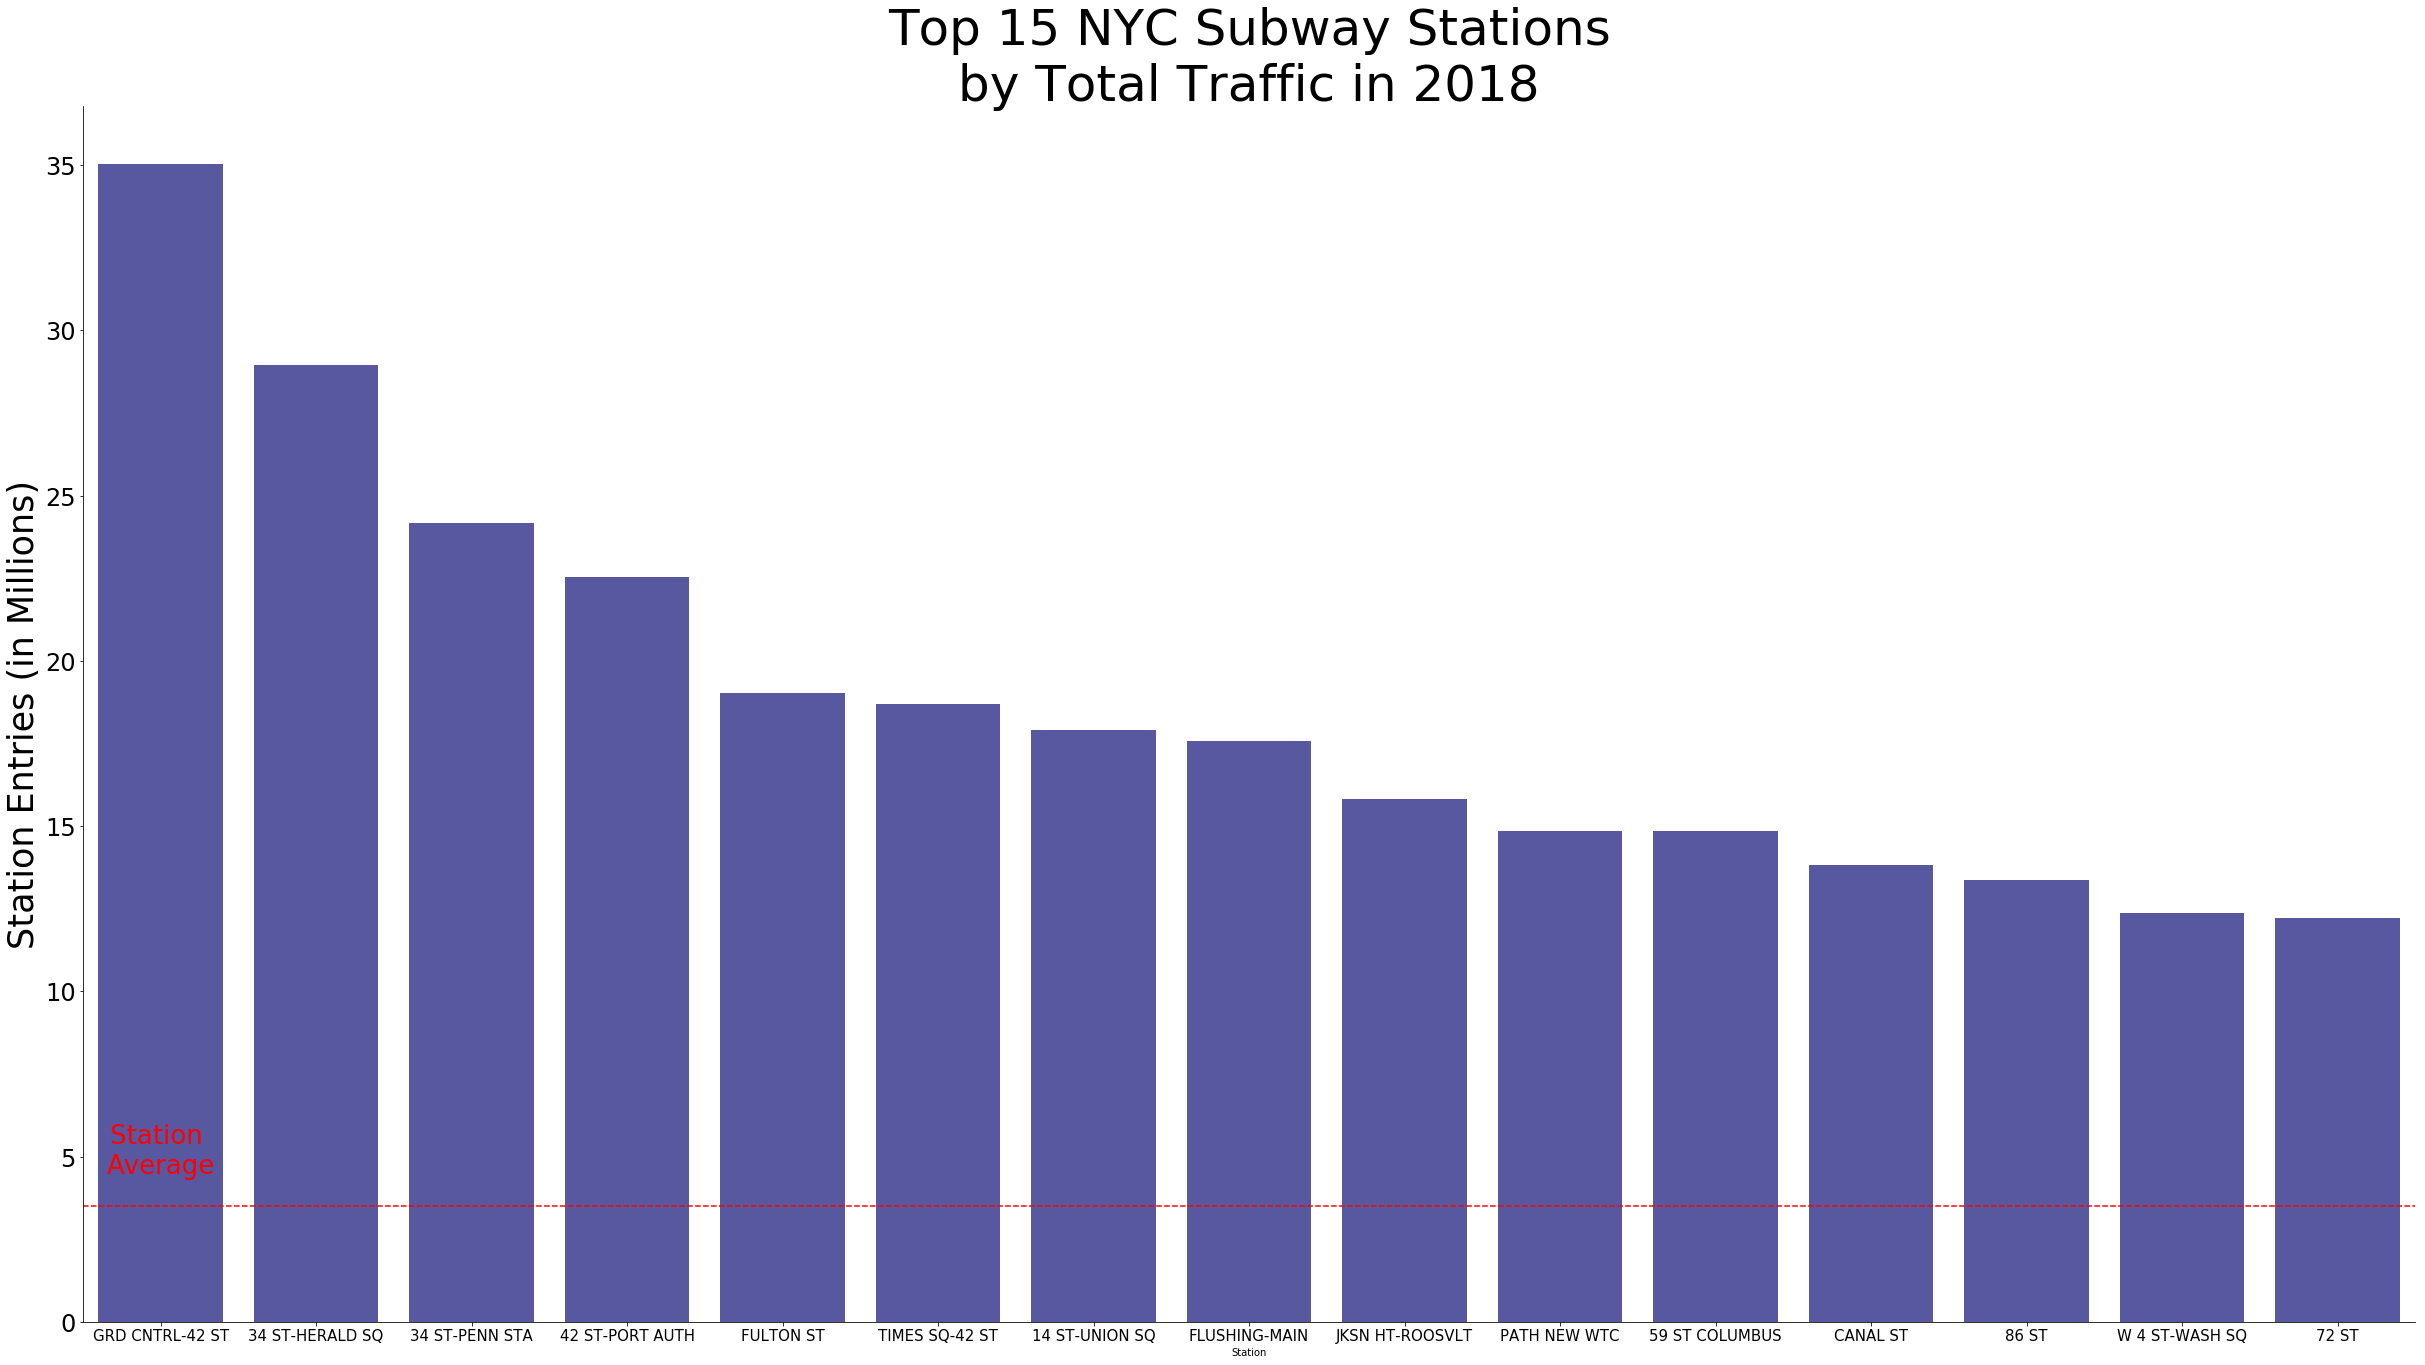

             STATION                   STATION_KEY  TOTAL_ENTRIES  \
314  GRD CNTRL-42 ST         GRD CNTRL-42 ST_4567S     35029174.0   
90   34 ST-HERALD SQ      34 ST-HERALD SQ_BDFMNQRW     28945094.0   
94    34 ST-PENN STA            34 ST-PENN STA_ACE     24168774.0   
103  42 ST-PORT AUTH  42 ST-PORT AUTH_ACENQRS1237W     22531056.0   
304        FULTON ST            FULTON ST_2345ACJZ     19028130.0   
450   TIMES SQ-42 ST   TIMES SQ-42 ST_1237ACENQRSW     18686967.0   
28    14 ST-UNION SQ       14 ST-UNION SQ_LNQR456W     17908677.0   
291    FLUSHING-MAIN               FLUSHING-MAIN_7     17563020.0   
341  JKSN HT-ROOSVLT         JKSN HT-ROOSVLT_EFMR7     15820277.0   
406     PATH NEW WTC                PATH NEW WTC_1     14858657.0   
126   59 ST COLUMBUS          59 ST COLUMBUS_ABCD1     14843177.0   
236         CANAL ST              CANAL ST_JNQRZ6W     13824642.0   
157            86 ST                     86 ST_456     13381930.0   
462   W 4 ST-WASH SQ        W 4 ST

In [28]:
#Barplot
ordered_df = totalByStation2018.sort_values(by='TOTAL_ENTRIES', ascending=False).head(15)
g = sns.catplot(x='STATION',data=ordered_df, y='TOTAL_ENTRIES_IN_MILLIONS', color='darkblue', kind='bar', alpha = 0.7)
g.fig.set_size_inches(40,20)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=24)
plt.ticklabel_format(style='plain', axis='y')
plt.axhline(totalByStation2018['TOTAL_ENTRIES_IN_MILLIONS'].mean(), linestyle = '--', color = 'red')
plt.text(0,(totalByStation2018['TOTAL_ENTRIES_IN_MILLIONS'].mean()+1),'Station \nAverage', fontsize=26,  horizontalalignment='center', color='red')

plt.title('Top 15 NYC Subway Stations\nby Total Traffic in 2018', fontsize=50,loc='center')
plt.xlabel('Station')
plt.ylabel('Station Entries (in Millions)', size=35)
plt.show()

print(ordered_df)

print('\nThe average number of riders per station in 2018 was:', float('%.2f' % totalByStation2018['TOTAL_ENTRIES_IN_MILLIONS'].mean()), 'million')

### *Interactive map of station stops*

We are going to make an interactive map of station stops across the NYC subway. Stations with larger traffic will have larger markings than stations with less trasffic. We will utilize folium to make the maps.

In [29]:
import folium

First, we need to get geocodes (lat, long) for each NYC subway station.

In [30]:
stationInfo = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [31]:
stationInfo.tail()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
491,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville
492,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville
493,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville
494,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN
495,523,523,S11,SIR,Staten Island,Arthur Kill,SI,SIR,At Grade,40.516578,-74.242096,St George,Tottenville


In [32]:
stationInfo['Division'].unique()

array(['BMT', 'IND', 'IRT', 'SIR'], dtype=object)

We need to filter for NYC subway only.

In [33]:
stationInfo = stationInfo[(stationInfo['Division'].isin(['BMT', 'IND', 'IRT']))]

We need to clean up the file to match the file previously loaded. The station name is the key we need to match on, however, they are not the same in either file. Also, the turnstile file does not include station id's so we have to create a station ID to match on based on the station name and the lines that run through the station.

In [34]:
dailyTurnstile2018.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_STAMP,TEST,TURNSTILE,KEY,MAX_TIME,MIN_TIME,RANK,DAILY_ENTRIES,ANALYSIS,STATION_KEY
30566489,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,01/01/2018,00:00:00,REGULAR,2978881,2145752,2018-01-01,227.0,R001.00-00-00,R001.00-00-00.01/01/2018,20:00:00,00:00:00,0,227.0,1,WHITEHALL S-FRY_R1W
30566490,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,01/01/2018,04:00:00,REGULAR,2978993,2145800,2018-01-01,112.0,R001.00-00-00,R001.00-00-00.01/01/2018,20:00:00,00:00:00,1,112.0,1,WHITEHALL S-FRY_R1W
30566491,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,01/01/2018,08:00:00,REGULAR,2979091,2145830,2018-01-01,98.0,R001.00-00-00,R001.00-00-00.01/01/2018,20:00:00,00:00:00,2,98.0,1,WHITEHALL S-FRY_R1W
30566492,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,01/01/2018,12:00:00,REGULAR,2979295,2145906,2018-01-01,204.0,R001.00-00-00,R001.00-00-00.01/01/2018,20:00:00,00:00:00,3,204.0,1,WHITEHALL S-FRY_R1W
30566493,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,01/01/2018,16:00:00,REGULAR,2979799,2146021,2018-01-01,504.0,R001.00-00-00,R001.00-00-00.01/01/2018,20:00:00,00:00:00,4,504.0,1,WHITEHALL S-FRY_R1W


In [35]:
#Replace spaces in Daytime Routes
stationInfo['Daytime Routes'] = stationInfo['Daytime Routes'].replace(' ', '', regex=True)

#Capitalize all letters
stationInfo['Stop Name'] = stationInfo['Stop Name'].str.upper()

#Create key for stationInfo data
stationInfo['Station Key'] = stationInfo['Stop Name']+'_'+stationInfo['Daytime Routes']

In [36]:
#Get unique values for station names
firstList = list(dailyTurnstile2018['STATION_KEY'].unique())
firstlistDF = pd.DataFrame(dailyTurnstile2018['STATION_KEY'].unique())

Next, we are going to use difflib to get closest station name matches, then manually check each station match. If the station names is off, we are going to replace that station name with the correct one. Since we only have 300+ stations, manually checking each station should not take that much time. We will export the file, manually check each station is corresponding to the name in the data files, the upload back into our notebook.

In [37]:
import difflib
pd.options.display.max_rows = 999

In [38]:
stationInfo['Closest Name'] = stationInfo['Station Key'].apply(lambda x: difflib.get_close_matches(x,firstList, n=1, cutoff=0.5))

In [39]:
#Export station lists to a csv file to manually translate stations
stationInfo.to_csv('stationInfo.csv', index=True)
firstlistDF.to_csv('firstlistDF.csv', index=True)

Now that we have manually translated station names of the two files, we are going to upload that dictionary as a dataframe.

In [40]:
#Upload final transltion csv file into a dataframe
stationTranslation = pd.read_csv('stationInfo-finalDictionaryList.csv')

#Take only one valye for each Station_key to avoid redundancies
stationTranslation = stationTranslation.groupby('STATION_KEY').first().reset_index()

#Merge with ridership data for 2018
dailyTurnstile2018_v2 = dailyTurnstile2018.merge(stationTranslation, how='inner', on='STATION_KEY')

In [41]:
location_df = dailyTurnstile2018_v2[['DATE_STAMP', 'TIME', 'DAILY_ENTRIES', 'STATION', 'STATION_KEY', 'GTFS Latitude', 'GTFS Longitude']]

#Rename long and lat columns
location_df.rename(columns={"GTFS Latitude": "LAT", "GTFS Longitude": "LONG"}, inplace=True)

In [42]:
#Select the first occurrence of each station id
location_df.dropna(inplace=True)
locations = location_df.groupby(['STATION', 'STATION_KEY'], as_index=False)['LAT', 'LONG'].first()

In [43]:
locations.head()

,STATION,STATION_KEY,LAT,LONG
0,1 AV,1 AV_L,40.730953,-73.981628
1,103 ST,103 ST_1,40.799446,-73.968379
2,103 ST,103 ST_6,40.790600,-73.947478
3,103 ST,103 ST_BC,40.796092,-73.961454
4,103 ST-CORONA,103 ST-CORONA_7,40.749865,-73.862700


In [44]:
#Merge with ridership data for 2018
totalByStation2018_v2 = totalByStation2018.merge(locations, how='inner', on='STATION_KEY')

#### *Bubble Map*

Now that we have our dataframe in the format needed to make the map, let's go ahead and do that now.

In [46]:
#Make a map of New York
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")

for index, row in totalByStation2018_v2.iterrows():
    rides = row['TOTAL_ENTRIES_IN_MILLIONS']
    radius = rides/2
    
    #Generate the popup message that is shown on click.
    popup_text = "{}<br> Total Ridership 2018:<br> {} million"
    popup_text = popup_text.format(row['STATION_KEY'], round(row['TOTAL_ENTRIES_IN_MILLIONS'],2), rides)
    
    #Color station markers
    color="cornflowerblue"
    
    #Add circle marker to the folium map
    folium.CircleMarker(location=(row['LAT'], row['LONG']), radius=radius, color=color,fill=True, popup=folium.Popup(popup_text,max_width=1000)).add_to(folium_map)

#Print out Map
folium_map

## **Model Building**

For this next section, we are going to start building a model to predict ridership for 2019. We are going to cycle through many different time series methods of forecasting to determine which method minimizes error. Remember, we are going to use data from 2016-2018 to predict ridership for the first few months of 2019.

We are going to use Facebook's Prophet to forecast. We want to forecast daily traffic system wide. 

### *Prophet*

Our first forecasting method is with Facebook's Prophet. 

Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t)= g(t) + s(t) + h(t) + εt

- g(t): piecewise linear or logistic growth curve for modeling non-periodic changes in time series
- s(t): periodic changes (e.g. weekly/yearly seasonality)
- h(t): effects of holidays (user provided) with irregular schedules
- εt: error term accounts for any unusual changes not accommodated by the model
- Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique . Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

In [47]:
#By Station and day
forecast_station_df = analysis_df.groupby(['STATION', 'DATE_STAMP'], as_index=False)['DAILY_ENTRIES'].sum()

#By day
forecast_total_df = analysis_df.groupby(['DATE_STAMP'], as_index=False)['DAILY_ENTRIES'].sum()

In [48]:
train = forecast_total_df[(forecast_total_df['DATE_STAMP'] < '2018-01-01')]
test = forecast_total_df[(forecast_total_df['DATE_STAMP'] >= '2018-01-01')]

In [49]:
#Set DATE_STAMP as index
forecast_total_df.set_index('DATE_STAMP', inplace=True)
train.set_index('DATE_STAMP', inplace=True)
test.set_index('DATE_STAMP', inplace=True)

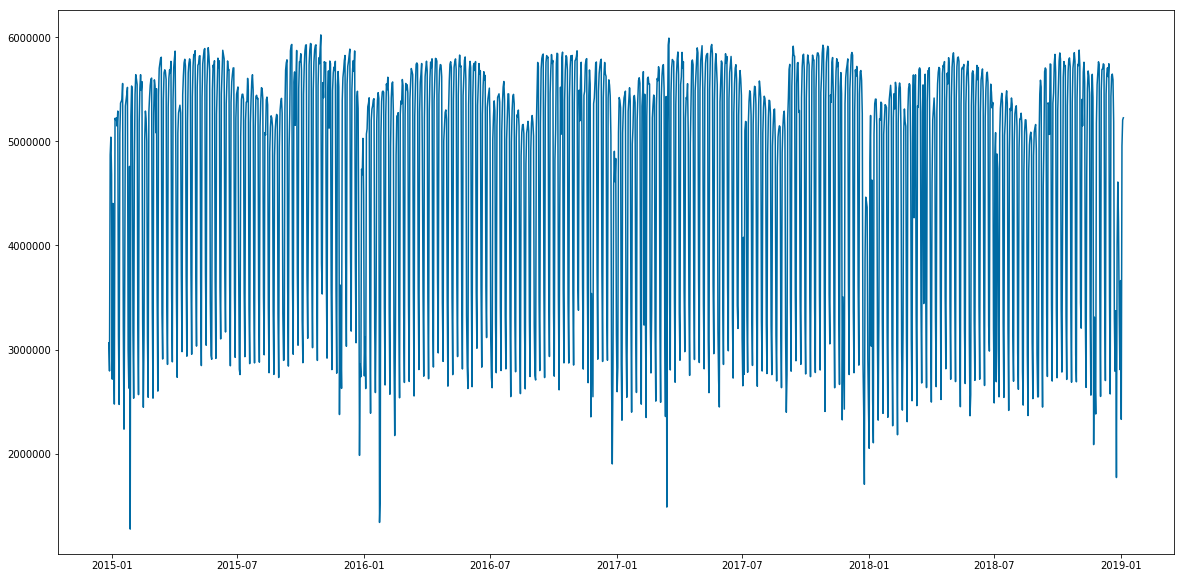

In [50]:
#Plot of ridership by day
plt.rcParams['figure.figsize']=(20,10)
plt.plot(forecast_total_df)
plt.show()

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


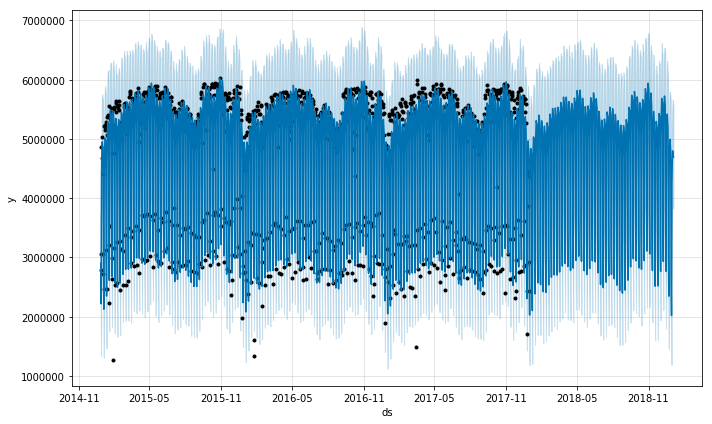

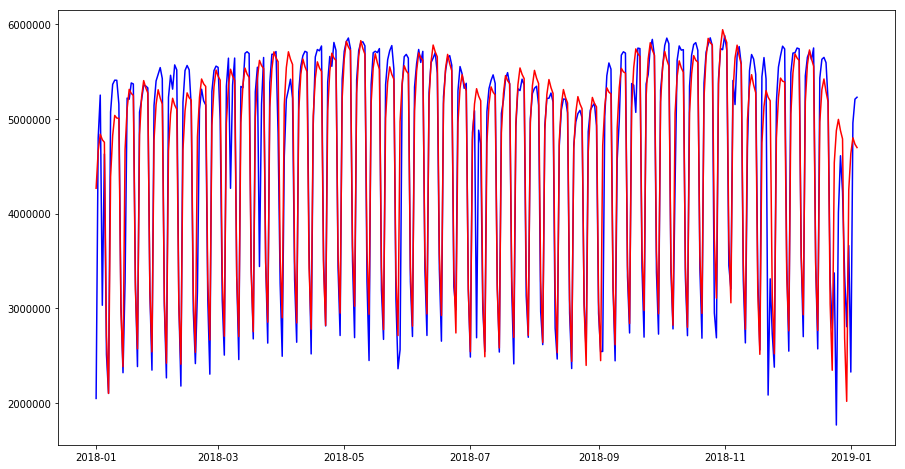

In [51]:
from fbprophet import Prophet
import pylab as pl
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

#Put data in prophet firndly format
df = train.reset_index()
df = df.rename(columns={'DATE_STAMP': 'ds', 'DAILY_ENTRIES': 'y'})

my_model.fit(df)

#Make furtur epredictions 
future_dates = my_model.make_future_dataframe(periods=369, include_history=True)

forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

my_model.plot(forecast)

#Select date and predictions
forecastPlot = forecast[['ds', 'yhat']]

#Set the date as the index
forecastPlot = forecastPlot.set_index('ds')

#Get the last 369 values of the forecast
forecastPlot = forecastPlot.tail(369)

#Plot train and test on same axis
pl.figure(figsize=(15,8)) 
pl.plot(test,'b')
pl.plot(forecastPlot,'r')
pl.show()

Looking at our plots, Prophet pretty acccurately forecasted traffic for 2018 (Forecast in red, actual in blue).

In [52]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print('RMSE:', np.sqrt(mean_squared_error(test.DAILY_ENTRIES, forecastPlot.yhat)))

RMSE: 486156.8253141033
